In [1]:
from IPython.core.interactiveshell import InteractiveShell
import os
import sys
import time
import multiprocessing as mp
from functools import partial
import pickle
import pixiedust
import PIL as pil
from matplotlib import pyplot as plt
import seaborn as sns
from collections import OrderedDict as ODict
import numpy as np
import pandas as pd

# KNN-Impute
import tensorflow as tf
from fancyimpute import KNN

InteractiveShell.ast_node_interactivity = 'all'

# %pixie_debugger
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
sns.set(style='white', context='notebook', palette='tab10')
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True

Pixiedust database opened successfully


Using TensorFlow backend.


## Import and Check data

In [2]:
datadir = os.getcwd() + '/../data'
filenames = ['train.csv', 'test.csv']
datadict = ODict()
for files in filenames:
    try:
        with open(datadir + '/' + files, mode='r') as csvfile:
            datadict[files] = pd.read_csv(csvfile, header=0, encoding='ascii')
            csvfile.close()
        print('found file: {}'.format(files))
    except FileNotFoundError:
        print('skipping file ./{}'.format(files))

datadict.keys(), filenames

found file: train.csv
found file: test.csv


(odict_keys(['train.csv', 'test.csv']), ['train.csv', 'test.csv'])

In [3]:
# %%
# Print out data, for quick look.

traindata = datadict[filenames[0]]
testdata = datadict[filenames[-1]]

print(traindata.shape[0],"Rows")

traindata.info()

891 Rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
# check sample sizes per class per column
len(traindata)/traindata.nunique()

PassengerId      1.000000
Survived       445.500000
Pclass         297.000000
Name             1.000000
Sex            445.500000
Age             10.125000
SibSp          127.285714
Parch          127.285714
Ticket           1.308370
Fare             3.592742
Cabin            6.061224
Embarked       297.000000
dtype: float64

## Exploratory data analysis

In [6]:
train_nulls = (traindata.isnull().sum() / len(traindata)) * 100
train_nulls = train_nulls.drop(train_nulls[train_nulls == 0].index)
test_nulls = (testdata.isnull().sum() / len(testdata)) * 100
test_nulls = test_nulls.drop(test_nulls[test_nulls == 0].index)
train_missing = pd.DataFrame({'Training NaNs' :train_nulls})
train_missing.index.name = 'Metric'
test_missing = (pd.DataFrame({'Test NaNs' :test_nulls}))
test_missing.index.name = 'Metric'
all_missing = pd.merge(train_missing, test_missing, on='Metric', how='outer')
all_missing.head()

,Training NaNs,Test NaNs
Metric,,
Age,19.865320,20.574163
Cabin,77.104377,78.229665
Embarked,0.224467,NaN
Fare,NaN,0.239234


In [7]:
# Fill empty's with NaNs
traindata = traindata.fillna(np.nan)
testdata = testdata.fillna(np.nan)

### Exploring our Variables

    * PassengerId -> Ignore
    * Pclass -> Categorical -> Survival Probability
    * Name -> Categorical with Title (after Extraction) -> Survival Probability
    * Sex -> Categorical -> Survival Probability
    * Age -> Continous / Categorical (Binned) -> Survival Probability
    * SibSP -> Categorical -> Survival Probability
    * Parch -> Categorical -> Survival Probability
    * Ticket -> ? -> Needs Features
    * Fare -> Continous / Categorical (Binned) -> Survival Probability
    * Cabin -> ? (Deck | Deck Position | ?) -> Needs Features
    * Embarked -> Categorical -> Survival Probability

,Survived
Pclass,
3,491
1,216
2,184


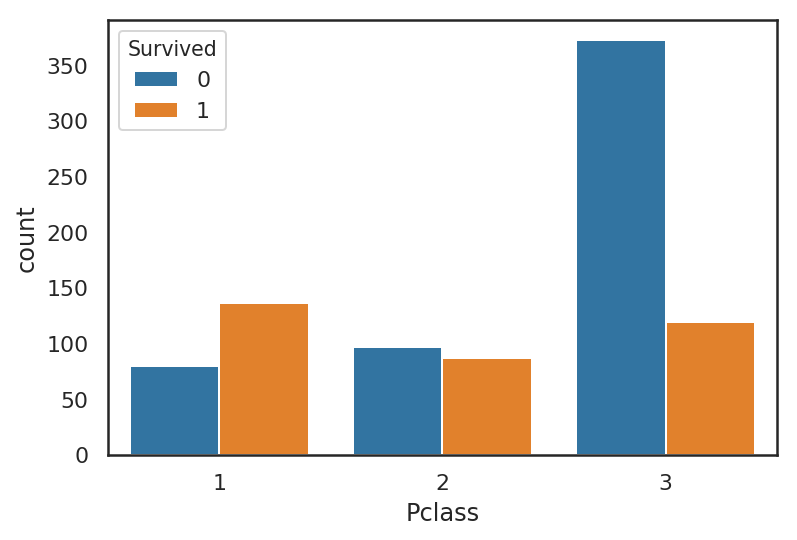

In [8]:
# Pclass
ax_pc = sns.countplot(x='Pclass',
                   hue="Survived",
                   data=traindata)

traindata[['Pclass',
           'Survived']].groupby('Pclass').count().sort_values(by='Survived',
                                                                    ascending=False)

Text(0, 0.5, 'Survival Probability')

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


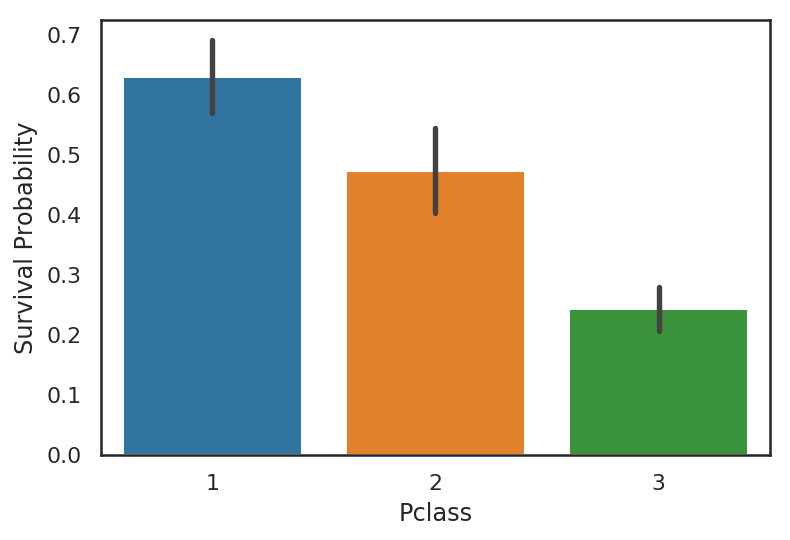

In [9]:
ax_pp = sns.barplot(x='Pclass',
                   y='Survived',
                   data=traindata)

ax_pp.set_ylabel("Survival Probability")

traindata[['Pclass',
           'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived',
                                                             ascending=False)

In [10]:
# Names

Prefixes = ['Mr.','Mrs.',
            'Master.','Miss.',
            'Don.','Dr.','Rev.',
            'Col.','Major.',
            'Ms.','Mme.','Lady.',
            'Sir.','Mlle.','Countess.',
            'Capt.','Jonkheer.']

def apply_prefix(s) -> str:
    
    Prefixes = ['Mr.','Mrs.','Master.','Miss.',
                'Don.','Dr.','Rev.','Col.',
                'Major.','Ms.','Mme.','Lady.',
                'Sir.','Mlle.','Countess.','Capt.','Jonkheer.']
    
    for _pf_ in Prefixes:
        if _pf_ in s:
            return _pf_
    return None

Pf_data = traindata.loc[:,('Name','Survived')]
Pf_data['Prefix'] = traindata.copy().loc[:,'Name'].astype(str).apply(apply_prefix) 

Text(0, 0.5, 'Survival Probability by Title')

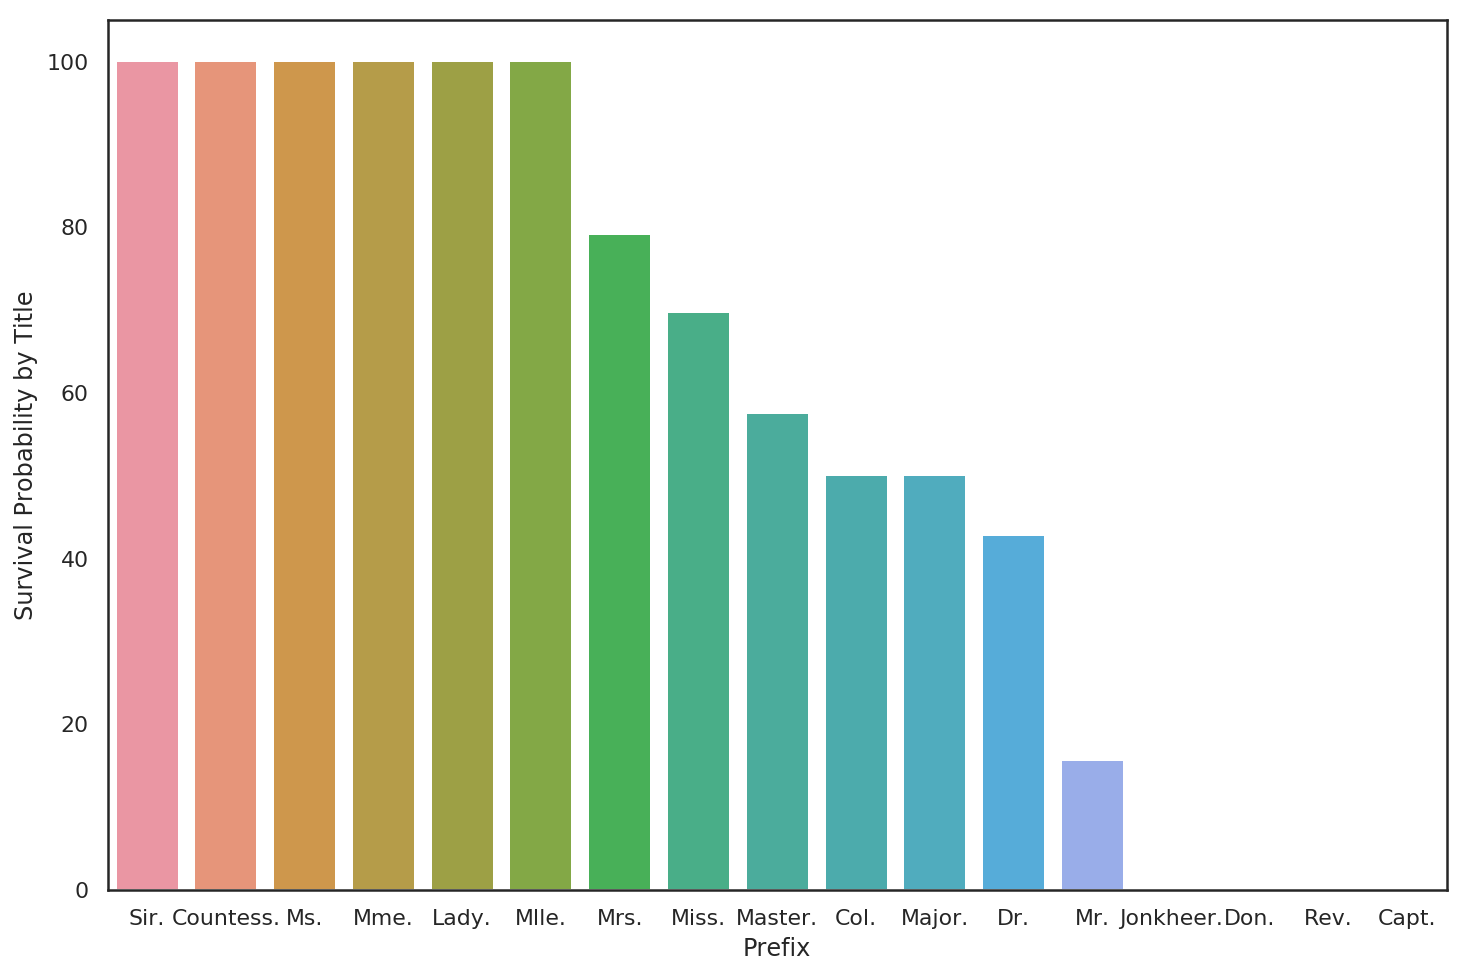

In [11]:
P = Pf_data[['Prefix',
             'Survived']].groupby('Prefix').mean().sort_values(by='Survived',
                                                               ascending=False) * 100
C = Pf_data[['Prefix',
             'Survived']].groupby('Prefix').count().sort_values(by='Survived',
                                                                ascending=False)
byNames = pd.merge(P,C,how='outer',on='Prefix')
byNames.columns = ['Survived(%)','Survived(N)']
byNames.index.name='Prefix'

fig = plt.figure(figsize=(12,8))

ax_np = sns.barplot(x=byNames.index,y=byNames['Survived(%)'])
ax_np.set_ylabel('Survival Probability by Title')

Text(0, 0.5, 'Survival Probability')

,Survived
Sex,
female,0.742038
male,0.188908


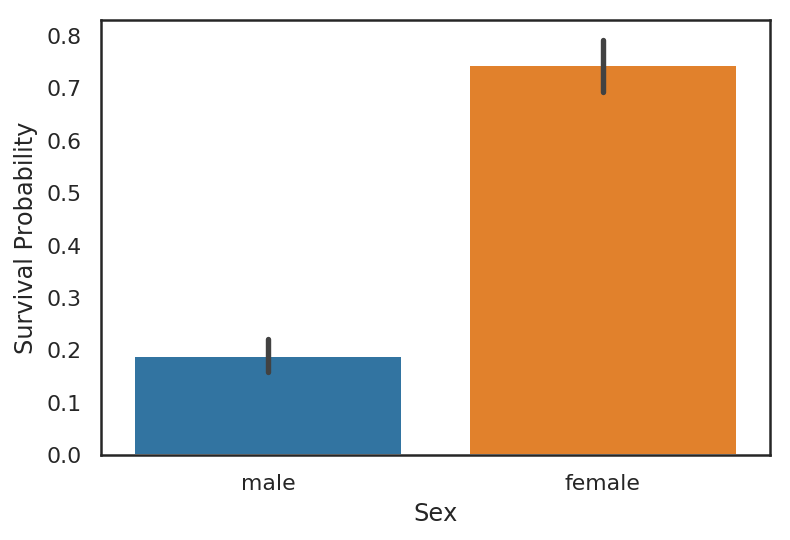

In [12]:
# by Gender

ax_gn = sns.barplot(x='Sex',y='Survived',data=traindata)
ax_gn.set_ylabel('Survival Probability')

traindata[['Sex','Survived']].groupby(['Sex']).mean()

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Survivors v/s Non Survivors by Age')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Probability')

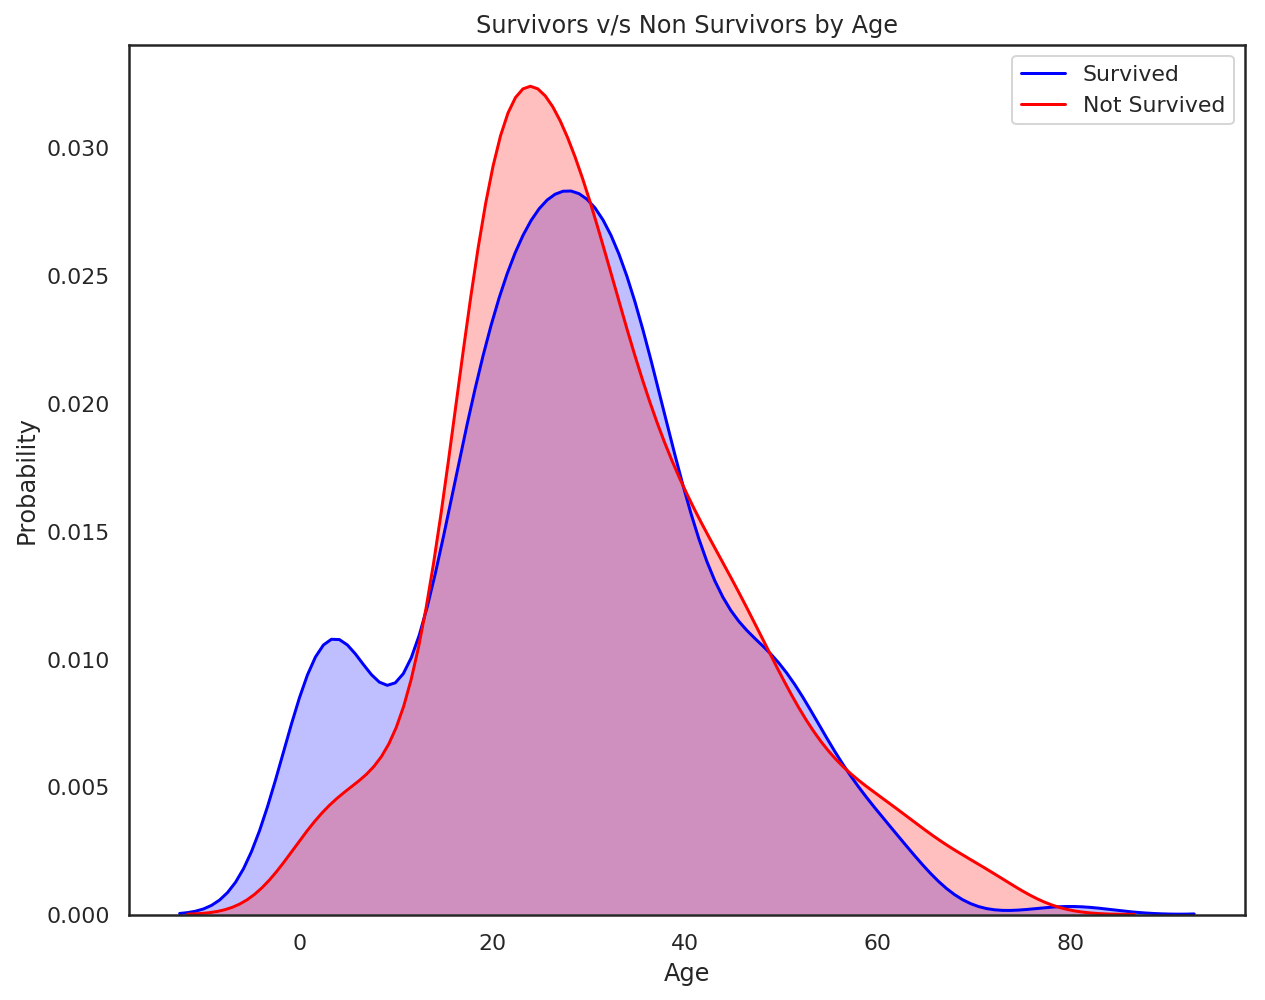

In [13]:
# by Age - Continuous KDE

fig = plt.figure(figsize=(10,8))

ax = sns.kdeplot(traindata.loc[(traindata['Survived']==1),('Age')],
                 color='b',
                 shade=True,
                 label='Survived')

ax = sns.kdeplot(traindata.loc[(traindata['Survived']==0),('Age')],
                 color='r',
                 shade=True,
                 label='Not Survived')

plt.title('Survivors v/s Non Survivors by Age')
plt.xlabel('Age')
plt.ylabel('Probability')

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Survival Probability by Age Group')

,Survived
Age_Binned,
0-10,0.593750
10-20,0.382609
20-30,0.365217
30-40,0.445161
40-50,0.383721
50-60,0.404762
60-70,0.235294
70-80,0.200000


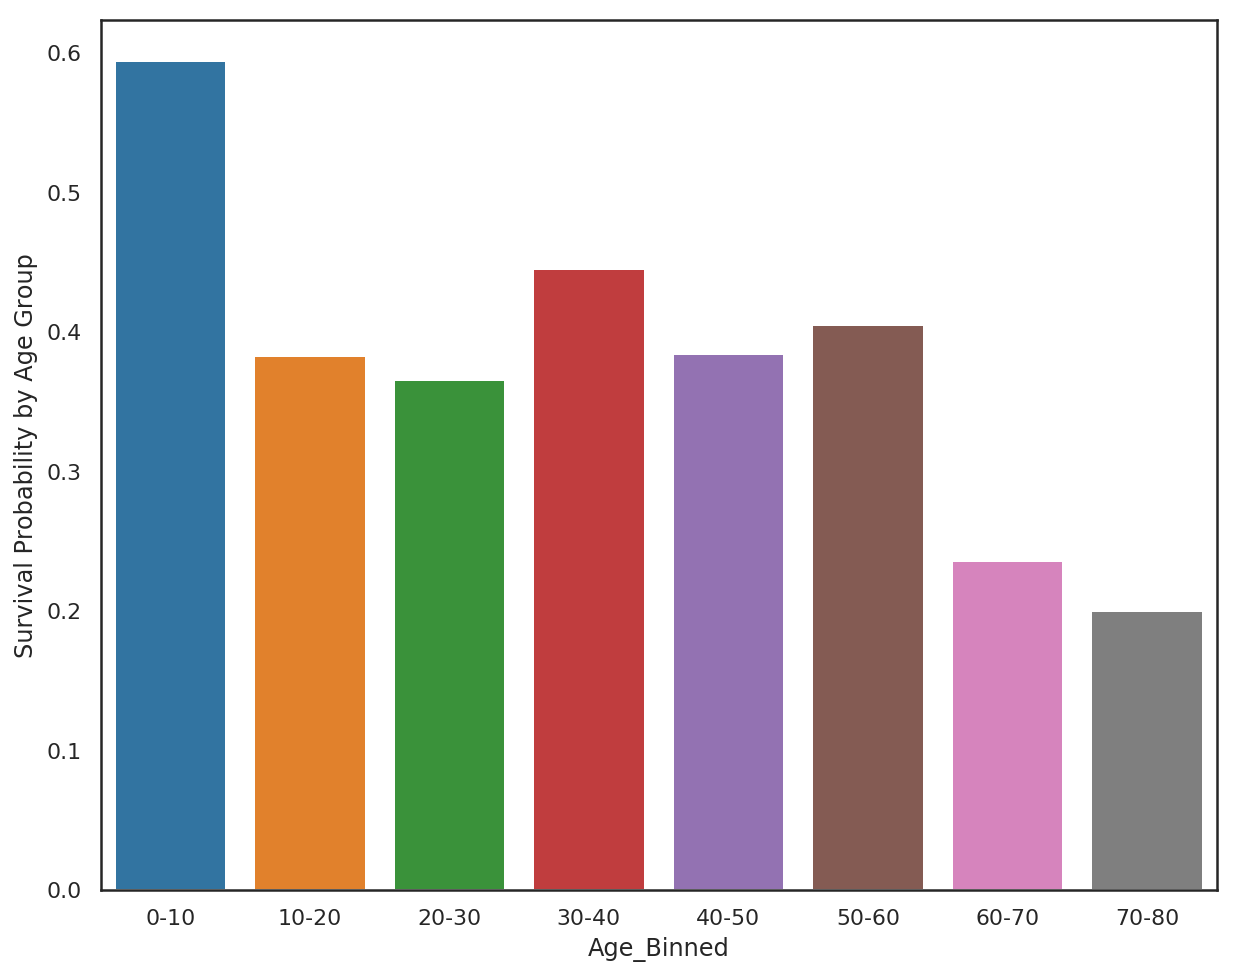

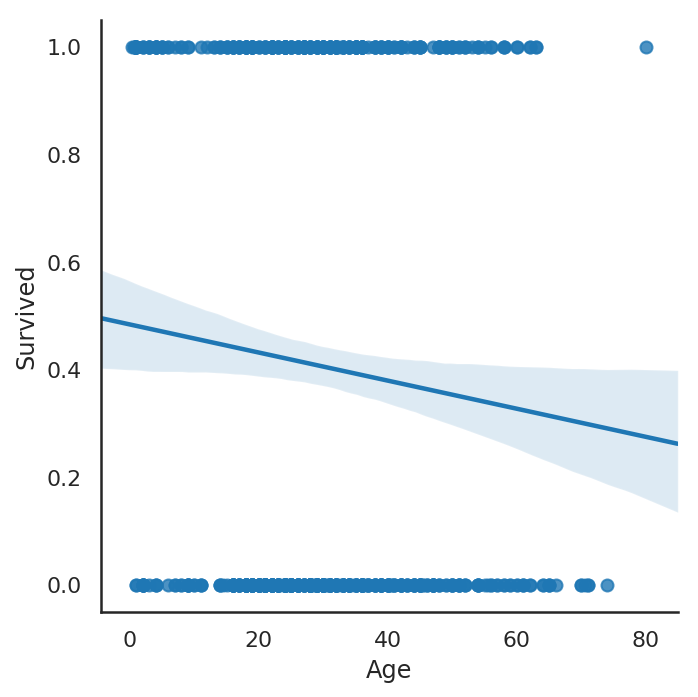

In [14]:
# by Age - Discrete Age Binning

fig = plt.figure(figsize=(10,8))

ageDF = traindata[['Age','Survived']]

maxage, minage = int(ageDF.Age.max()), int(ageDF.Age.min())
agebins = np.arange(minage, maxage+10, 10)
agelabels = [str(agebins[i])+'-'+str(agebins[i+1])
             for i in range(len(agebins)-1)]


ageDF['Age_Binned'] = pd.cut(ageDF.loc[:,('Age')],
                             bins=agebins,
                             labels=agelabels)


Binned_Probs = ageDF[['Age_Binned','Survived']].groupby(['Age_Binned']).mean()

ax_ag = sns.barplot(x=Binned_Probs.index,
                    y='Survived', 
                    data=Binned_Probs)

ax_lmag = sns.lmplot('Age','Survived',data=ageDF)

ax_ag.set_ylabel('Survival Probability by Age Group')

Binned_Probs

Text(0, 0.5, 'Survival Probabibility')

Text(0.5, 0, 'Number of siblings on board')

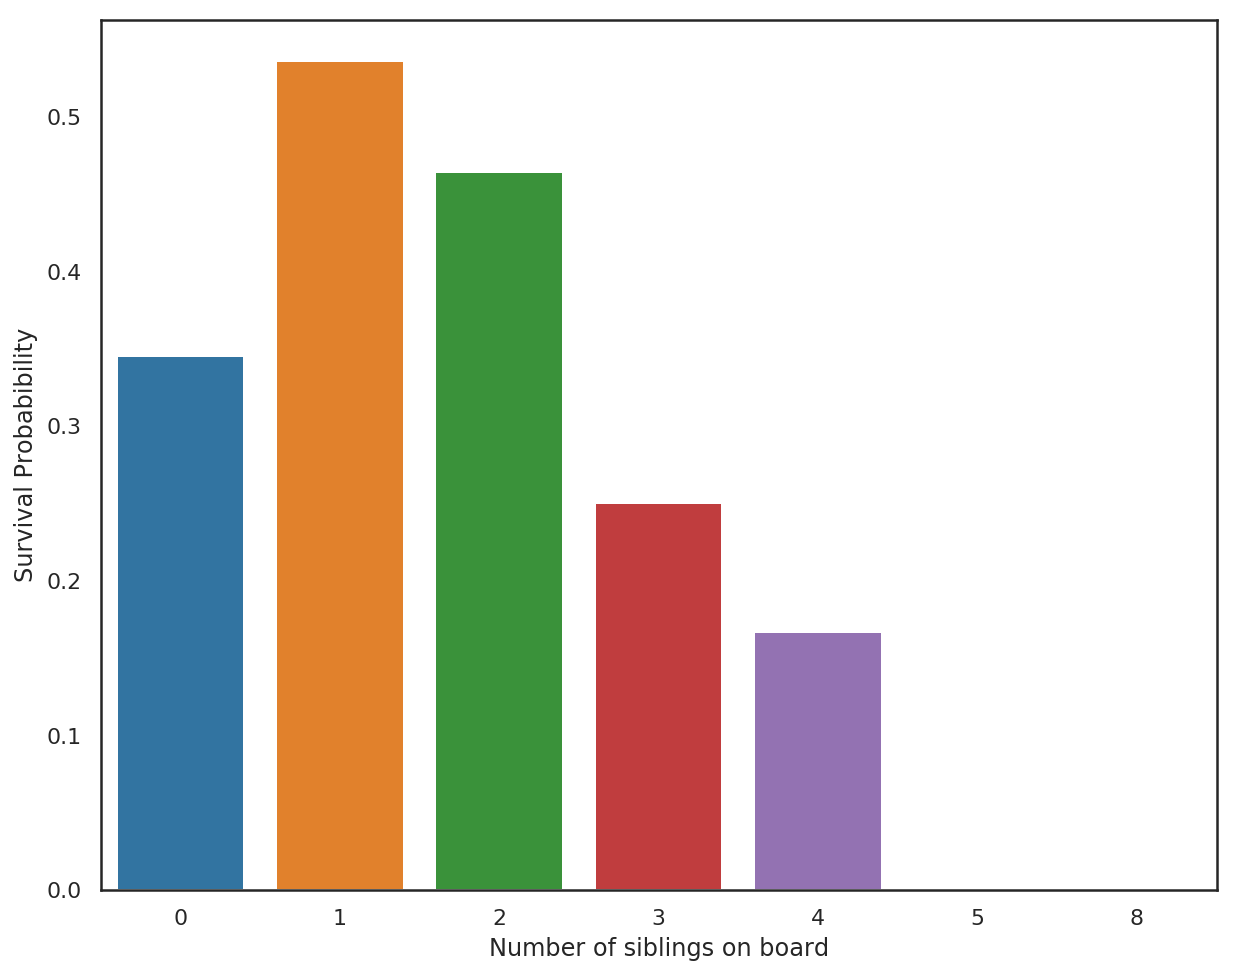

In [15]:
# by siblings on board

fig = plt.figure(figsize=(10,8))

sib_data = traindata[['SibSp', 'Survived']].groupby(['SibSp']).mean()

ax_sb = sns.barplot(x=sib_data.index, y='Survived', data=sib_data)
ax_sb.set_ylabel('Survival Probabibility')
ax_sb.set_xlabel('Number of siblings on board')

Text(0, 0.5, 'Survival Probabibility')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


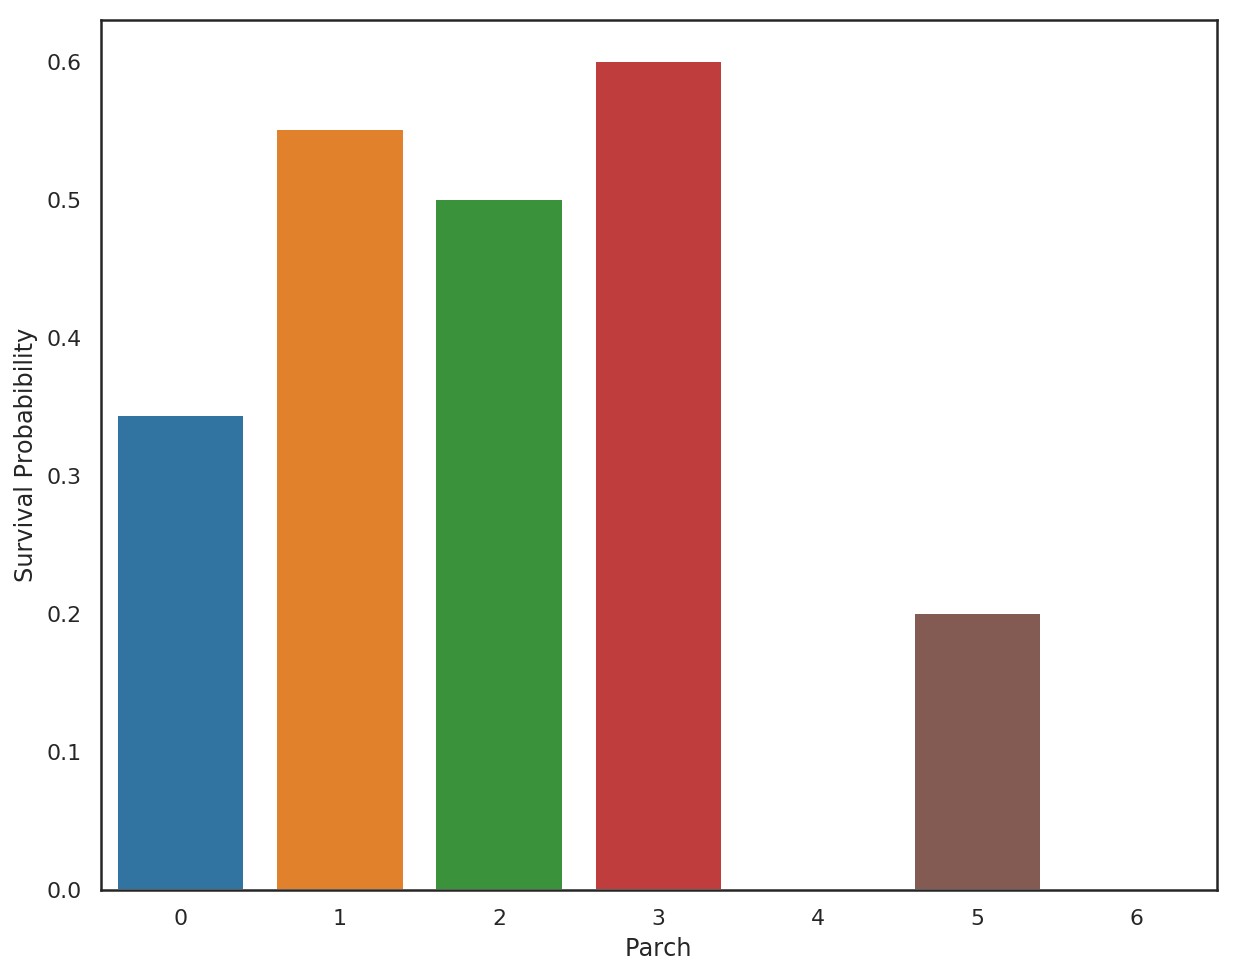

In [16]:
# by parents on board

fig = plt.figure(figsize=(10,8))

Parch_data = traindata[['Parch', 'Survived']].groupby(['Parch']).mean()

ax_sb = sns.barplot(x=Parch_data.index, y='Survived', data=Parch_data)
ax_sb.set_ylabel('Survival Probabibility')

Parch_data

Text(0.5, 1.0, 'Survivors v/s Non Survivors by Fare')

Text(0.5, 0, 'Fare')

Text(0, 0.5, 'Probability')

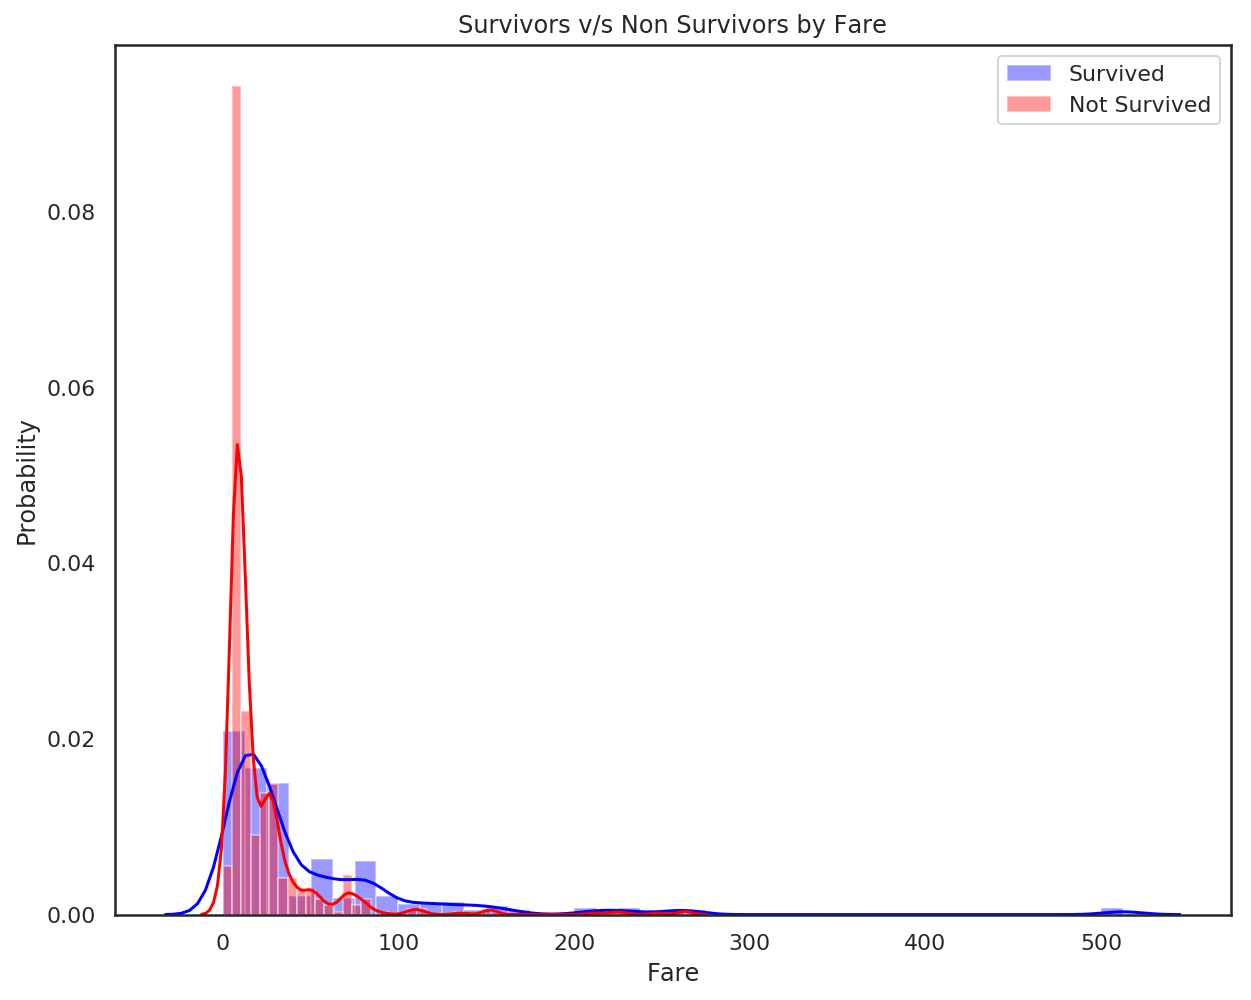

In [17]:
# by fares

fig = plt.figure(figsize=(10,8))

ax = sns.distplot(traindata.loc[(traindata['Survived']==1),('Fare')],
                 color='b',
                 label='Survived')

ax = sns.distplot(traindata.loc[(traindata['Survived']==0),('Fare')],
                 color='r',
                 label='Not Survived')

plt.title('Survivors v/s Non Survivors by Fare')
plt.legend()
plt.xlabel('Fare')
plt.ylabel('Probability')

In [18]:
# Cabin
traindata['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Text(0, 0.5, 'Count')

,Survived
Embarked,
C,168
Q,77
S,644


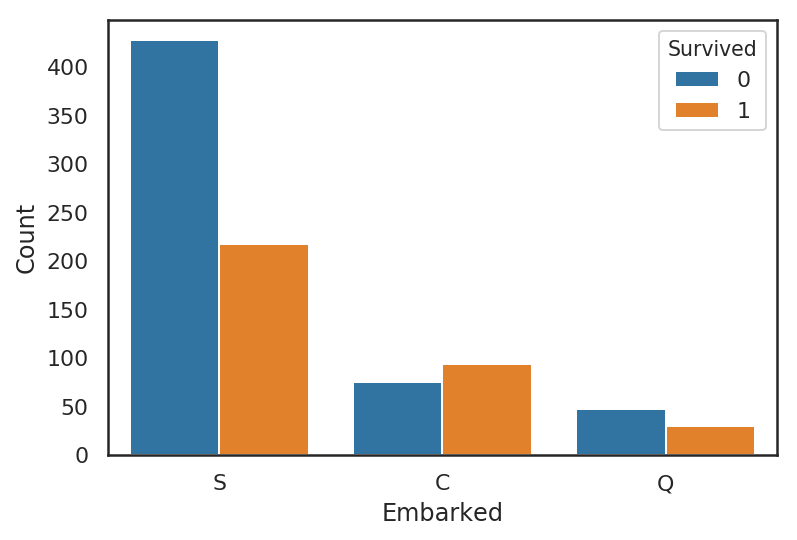

In [19]:
# Embarked
ax = sns.countplot(x='Embarked',hue='Survived',data=traindata)
ax.set_ylabel('Count')

traindata[['Embarked','Survived']].groupby(['Embarked']).count()

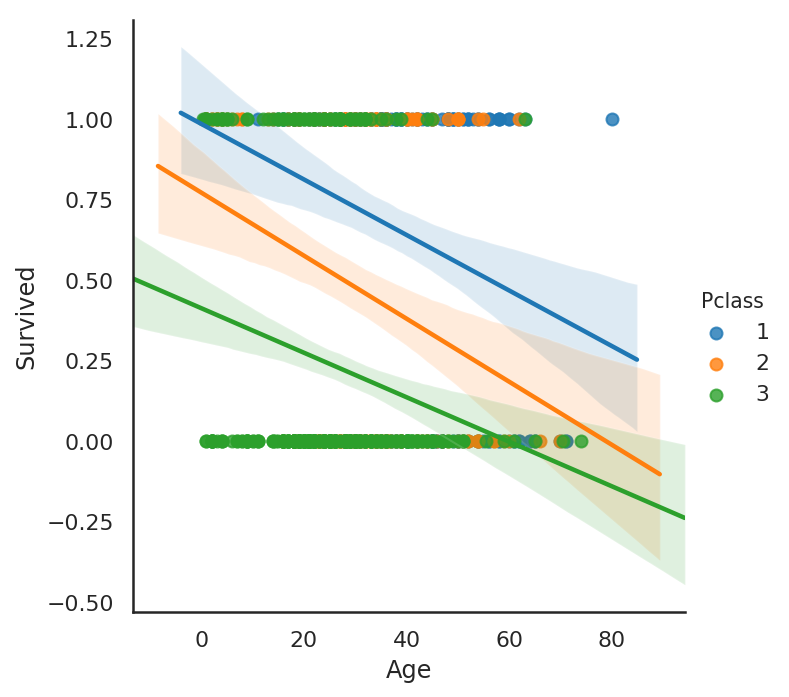

In [20]:
# Multiplots
# Age and Pclass

sns.lmplot('Age', 'Survived', data=traindata, hue='Pclass')

<Figure size 1152x384 with 0 Axes>

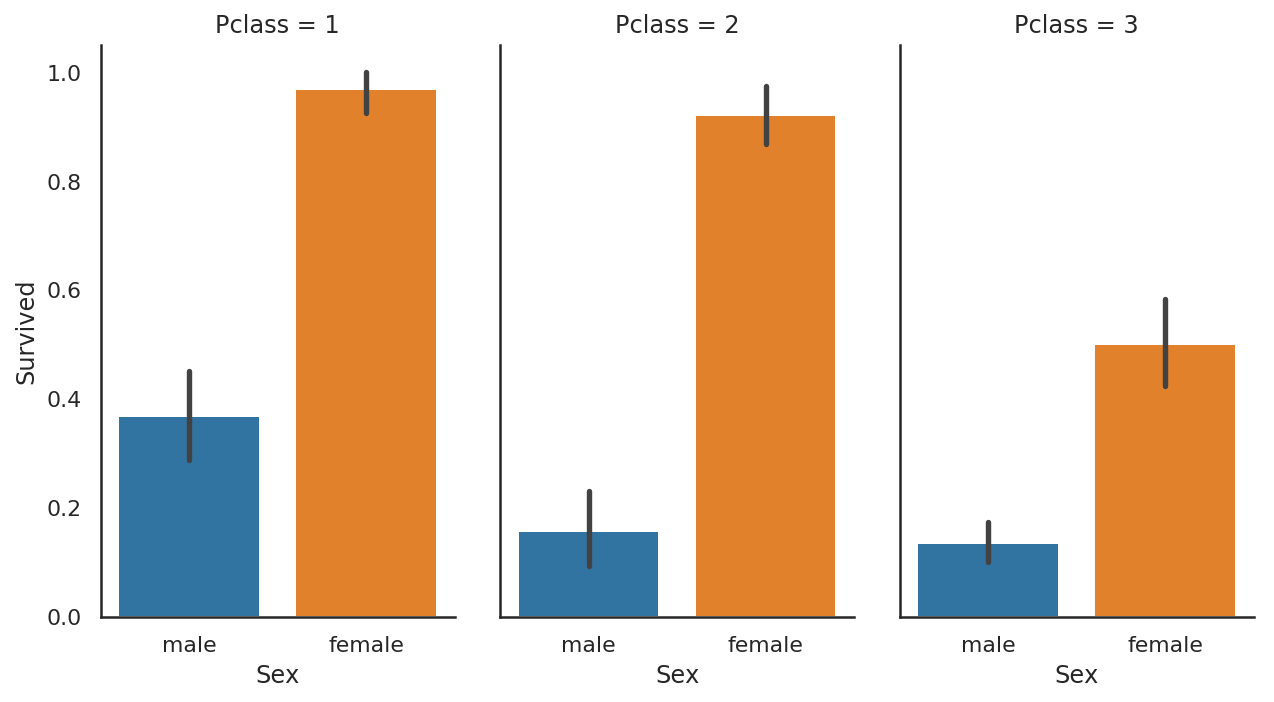

In [21]:
# Age, Sex and Pclass
fig = plt.figure(figsize=(12,4), dpi=96)
sns.catplot(x='Sex', y='Survived', col='Pclass', 
            data=traindata, kind='bar', aspect=0.6)

<Figure size 2688x384 with 0 Axes>

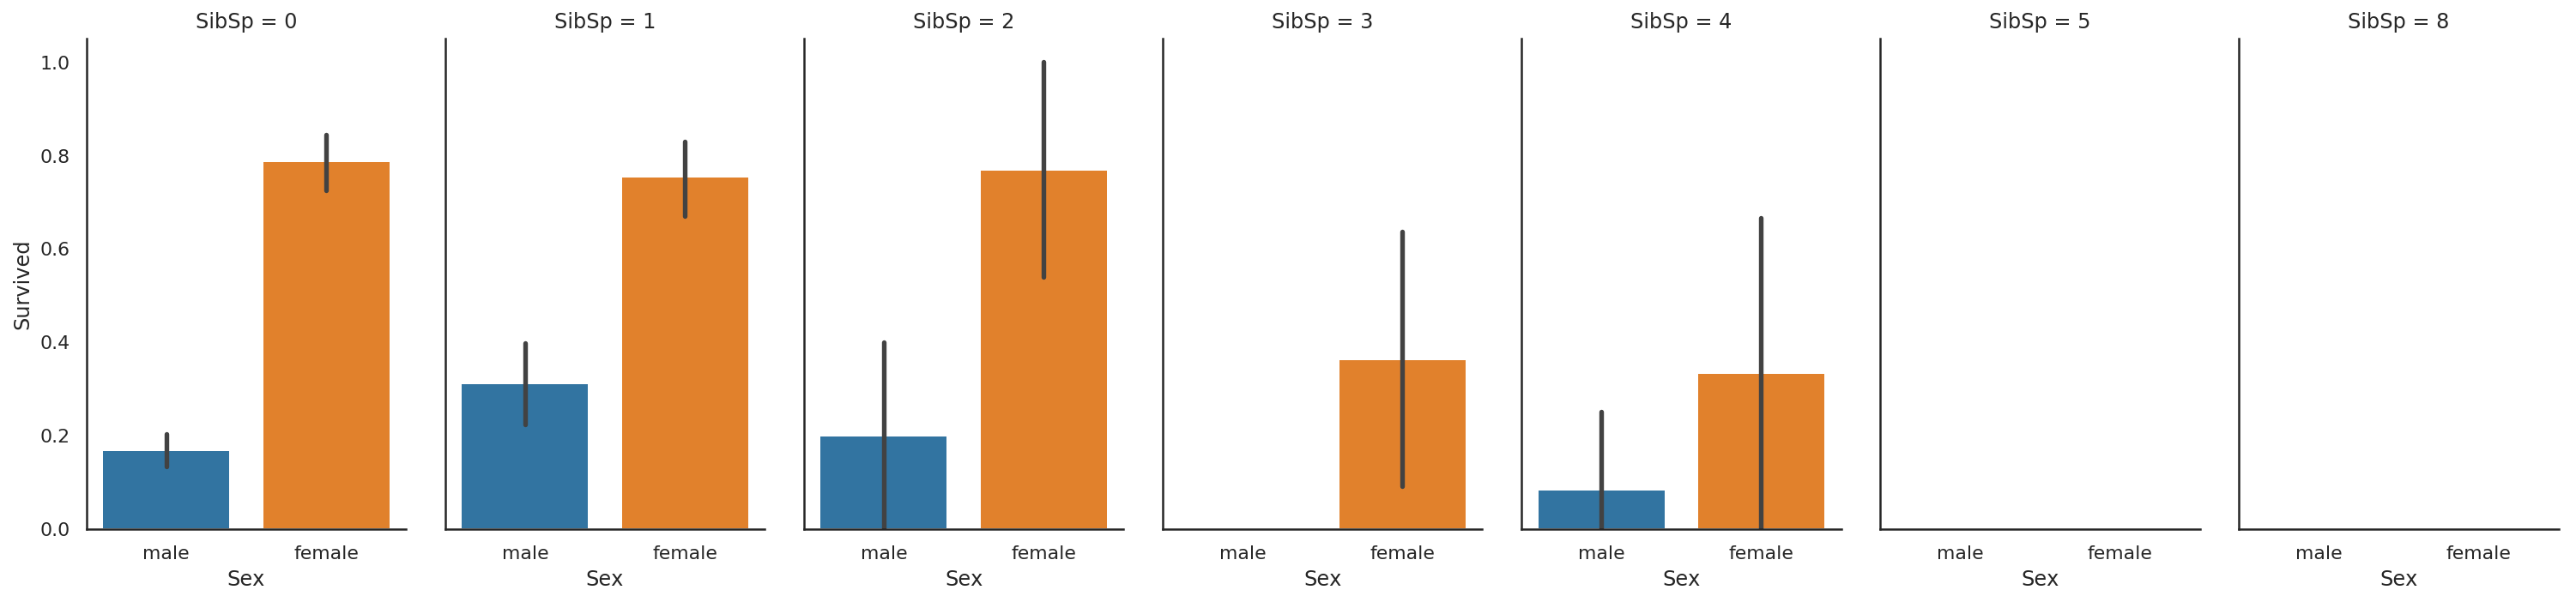

In [22]:
# Age, Sex, and Siblings on board
fig = plt.figure(figsize=(28,4), dpi=96)
sns.catplot(x='Sex', y='Survived', col='SibSp', 
            data=traindata, kind='bar', aspect=0.6)

<Figure size 2688x384 with 0 Axes>

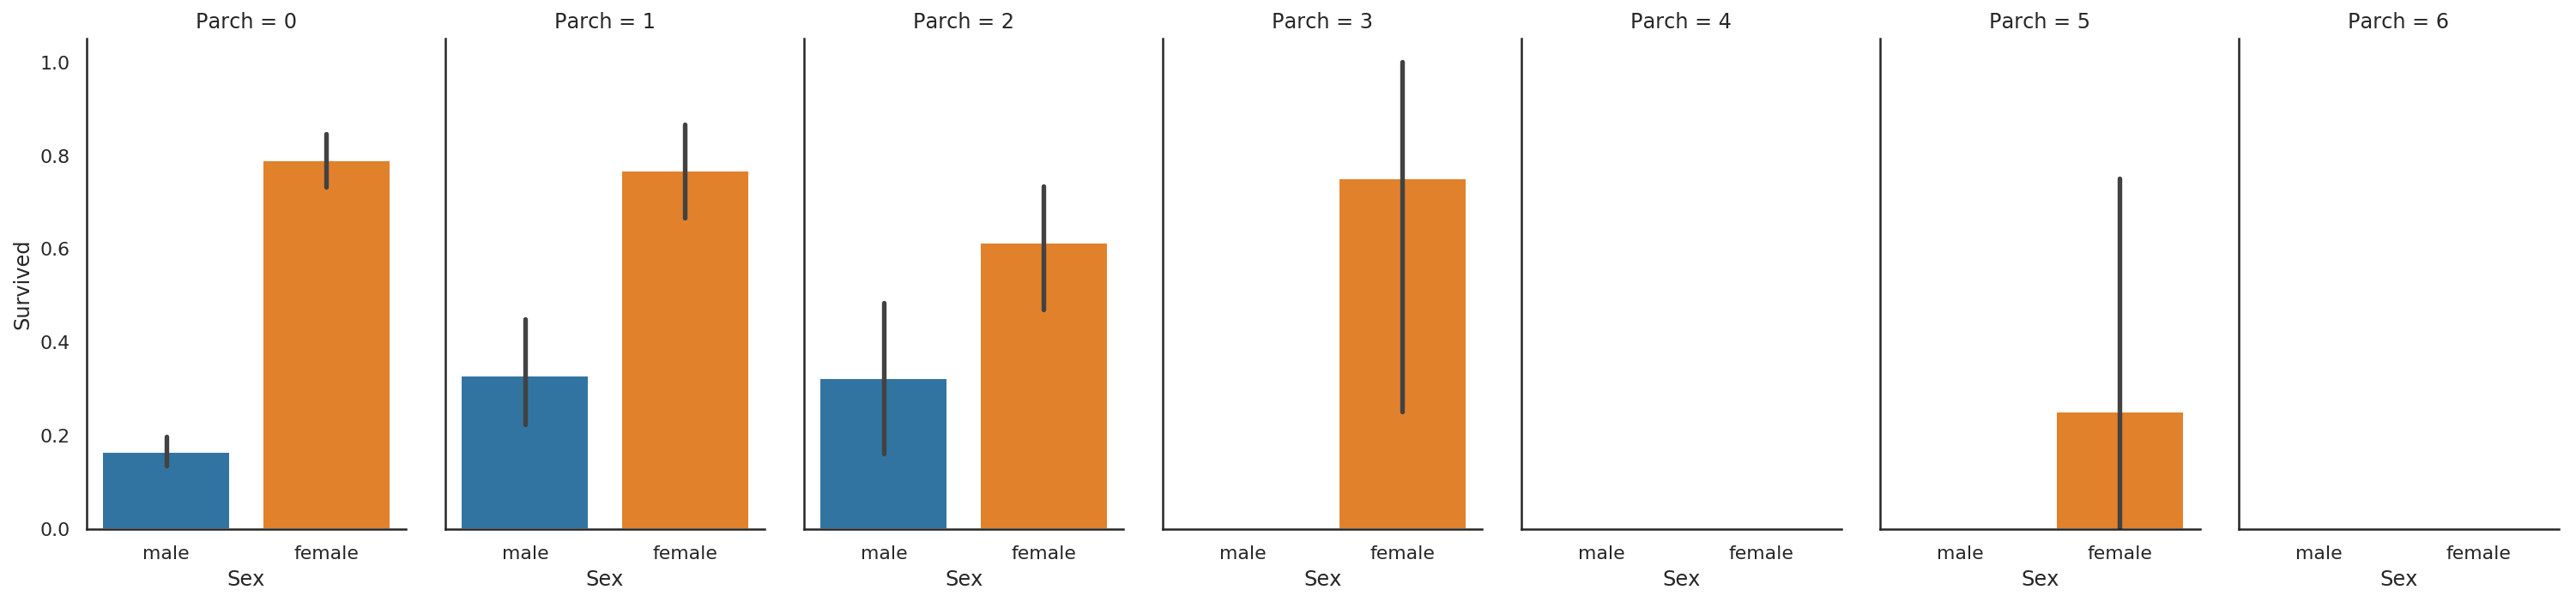

In [23]:
#Age, Sex and Parch
fig = plt.figure(figsize=(28,4), dpi=96)
sns.catplot(x='Sex', y='Survived', col='Parch', 
            data=traindata, kind='bar', aspect=0.6)

## Feature Engineering

In [24]:
# combining data

traindata['origin'] = 'train'
testdata['origin'] = 'test'
alldata = pd.concat([traindata, testdata], ignore_index=True, sort=False)
print(traindata.shape, testdata.shape, alldata.shape)
print(set(traindata.columns) - set(testdata.columns))
alldata.isnull().sum()

(891, 13) (418, 12) (1309, 13)
{'Survived'}


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
origin            0
dtype: int64

In [25]:
# passengerID -> droppping

alldata.drop(labels = ['PassengerId'], axis=1, inplace=True)
alldata.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,origin
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


We won't be using dummies, instead relying on gaussian properties.

In [26]:
# Pclass - make categorical
alldata['Pclass'] = alldata.Pclass.astype('category')
alldata['Pclass'].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [27]:
# Name - Extract Prefixes
alldata['Prefix'] = alldata.astype(str).apply(lambda s: pd.Series(apply_prefix(s["Name"])),axis=1)
print(alldata.Prefix.unique())
alldata['Prefix'] = alldata.Prefix.astype('category').cat.codes
alldata['Prefix'] = alldata['Prefix'] + 2
alldata['Prefix'].value_counts()

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'Countess.' 'Jonkheer.' nan]


14    757
11    260
15    197
10     61
17      8
6       8
3       4
9       2
16      2
12      2
5       1
2       1
4       1
18      1
7       1
8       1
13      1
1       1
Name: Prefix, dtype: int64

In [28]:
# check progress
alldata.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'origin', 'Prefix'],
      dtype='object')

In [29]:
#Name -> Drop Raw Names
alldata.drop(labels = ['Name'], axis=1, inplace=True)
# check progress
alldata.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'origin', 'Prefix'],
      dtype='object')

In [30]:
#Sex -> Categorize
alldata['Sex'] = alldata.Sex.astype('category').cat.codes + 1
alldata['Sex'].value_counts()

2    843
1    466
Name: Sex, dtype: int64

In [31]:
alldata.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'origin', 'Prefix'],
      dtype='object')

In [32]:
def KNNfill(df,usecols,predcol, knn_k=5):
    
    dfcpy = df.copy().fillna(value=float('NaN')).loc[:, usecols]
    minval = dfcpy.loc[dfcpy[predcol].notnull(),(predcol)].min()
    meanval = dfcpy.loc[dfcpy[predcol].notnull(),(predcol)].mean()
    maxval = dfcpy.loc[dfcpy[predcol].notnull(),(predcol)].max()
    
    predictor = KNN(k=knn_k, min_value=minval, max_value=maxval)
    print("Starting Imputation, Printing NaNs for Passed DataFrame::\n{}\n".format(dfcpy.isnull().sum()))
    print("{} values missing for {}".format(dfcpy[predcol].isnull().sum(),predcol))
    imputed_df = pd.DataFrame(data=predictor.fit_transform(dfcpy),
                             columns=usecols)
    imputed_df['orig_'+predcol] = dfcpy.loc[:, (predcol)]
    return imputed_df

In [33]:
usecols = ['Sex', 'Prefix', 'Pclass', 'Parch', 'SibSp', 'Fare', 'Age']

# fill Fare with mean
tempfare = alldata.copy()
tempfare.loc[np.isnan(alldata.Fare),['Fare']] = tempfare.loc[:,'Fare'].mean()

imputed_df = KNNfill(tempfare, usecols, 'Age')

alldata['Age'] = imputed_df.Age

print("OK!" if alldata.Age.isnull().sum()==0 else "Imputation Failed!")

imputed_df.loc[imputed_df['orig_Age'].isnull(),('orig_Age','Age')].head()

Starting Imputation, Printing NaNs for Passed DataFrame::
Sex         0
Prefix      0
Pclass      0
Parch       0
SibSp       0
Fare        0
Age       263
dtype: int64

263 values missing for Age
Imputing row 1/1309 with 0 missing, elapsed time: 0.183
Imputing row 101/1309 with 0 missing, elapsed time: 0.183
Imputing row 201/1309 with 0 missing, elapsed time: 0.184
Imputing row 301/1309 with 1 missing, elapsed time: 0.185
Imputing row 401/1309 with 0 missing, elapsed time: 0.185
Imputing row 501/1309 with 0 missing, elapsed time: 0.186
Imputing row 601/1309 with 0 missing, elapsed time: 0.187
Imputing row 701/1309 with 0 missing, elapsed time: 0.187
Imputing row 801/1309 with 0 missing, elapsed time: 0.188
Imputing row 901/1309 with 0 missing, elapsed time: 0.188
Imputing row 1001/1309 with 0 missing, elapsed time: 0.189
Imputing row 1101/1309 with 0 missing, elapsed time: 0.190
Imputing row 1201/1309 with 0 missing, elapsed time: 0.190
Imputing row 1301/1309 with 0 missing, elapsed t

,orig_Age,Age
5,NaN,21.720221
17,NaN,31.500000
19,NaN,38.117413
26,NaN,26.700000
28,NaN,21.376997


In [34]:
# discretize age to 10 year bins.

alldata['Age'] = alldata['Age'].map(lambda s: int((int(s)//5)))
alldata['Age'] = alldata['Age'].astype(np.int8)
print(sorted(list(alldata['Age'].unique())))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


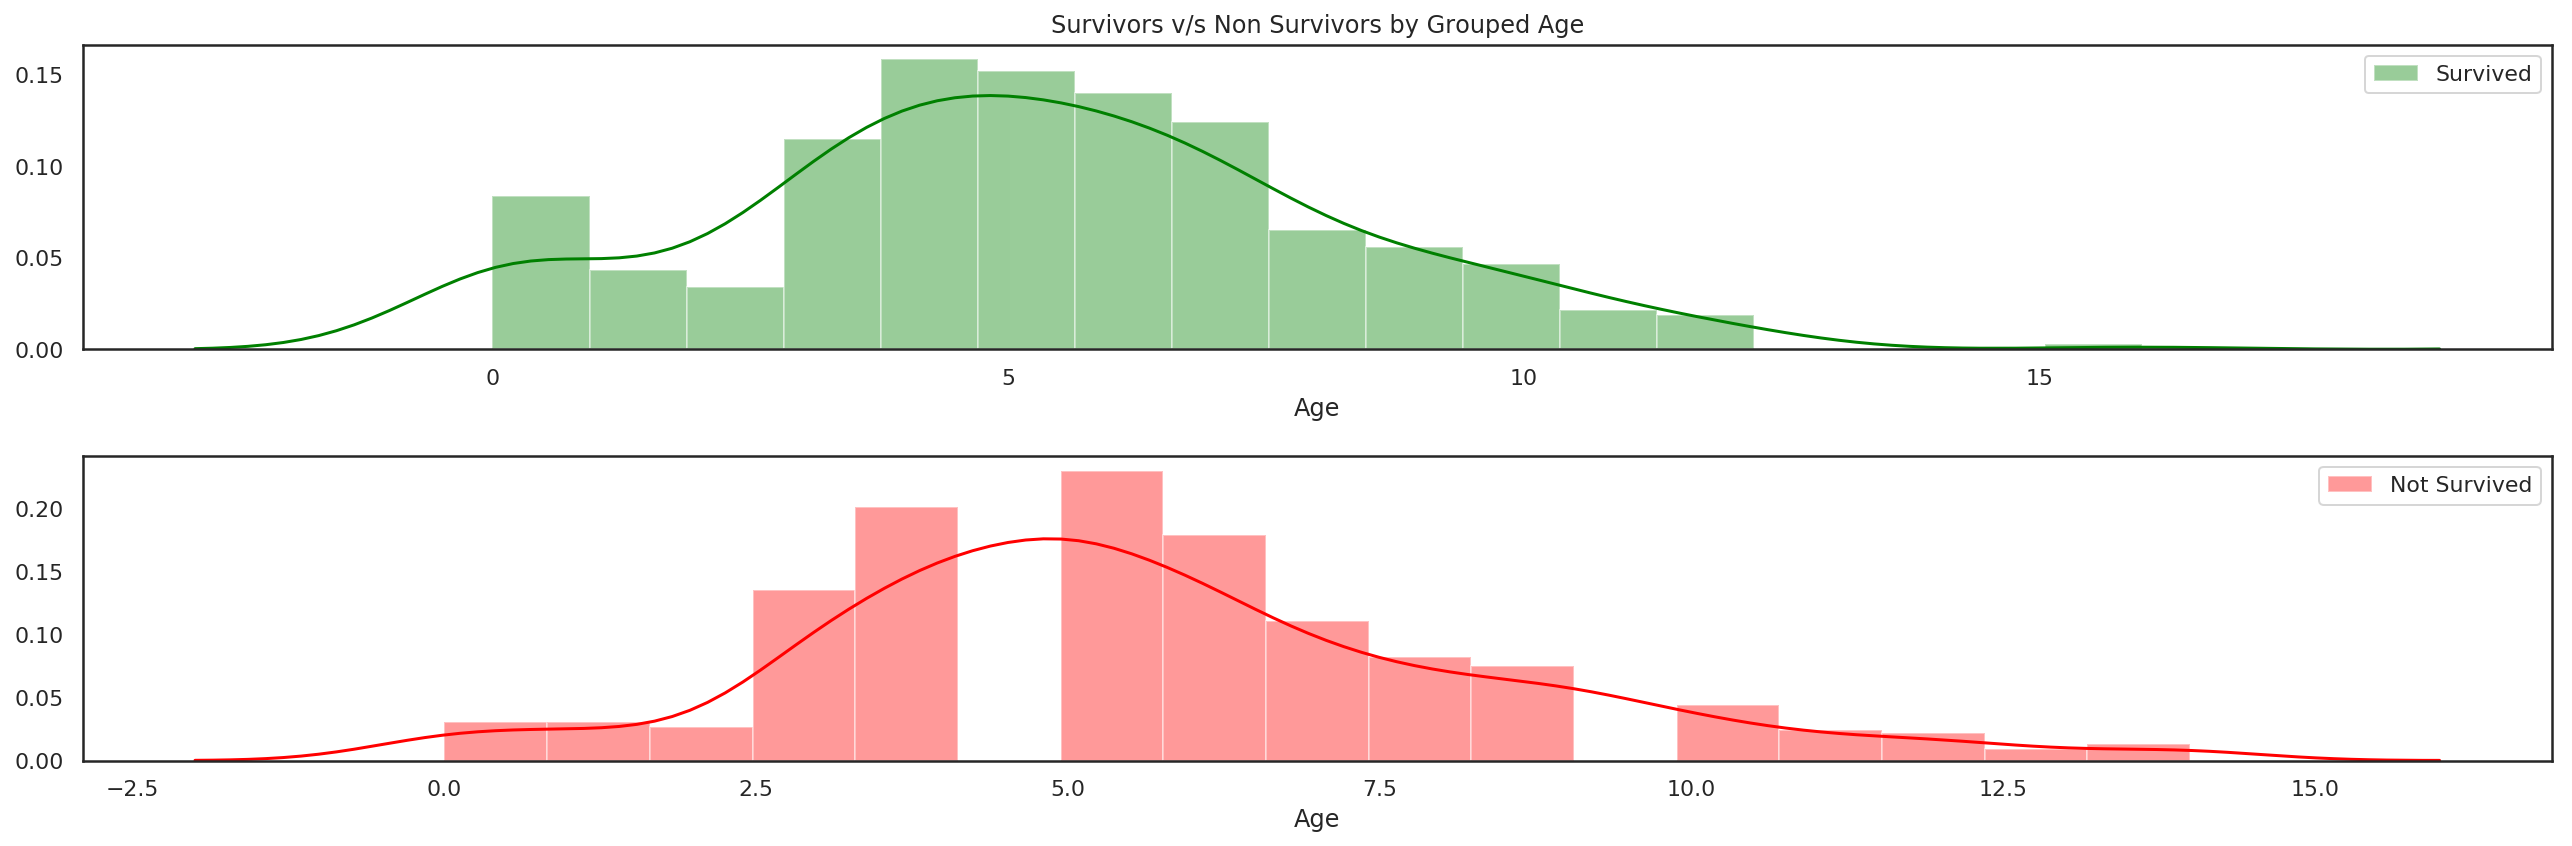

In [35]:
fig, ax_ag = plt.subplots(2, 1, figsize=(18,6))

ax_ag[0] = sns.distplot(alldata.loc[(alldata['Survived']==1),('Age')], 
                        bins=17, color='g', kde=True, hist=True,
                        label='Survived', ax = ax_ag[0])
ax_ag[1] = sns.distplot(alldata.loc[(alldata['Survived']==0),('Age')],
                        bins=17, color='r', kde=True, hist=True,
                        label='Not Survived', ax = ax_ag[1])
_ = ax_ag[0].set_title('Survivors v/s Non Survivors by Grouped Age', loc='center')
_ = ax_ag[0].legend()
_ = ax_ag[1].legend()
plt.tight_layout()

In [36]:
# categorical cast

alldata['Age'] = alldata.Age.astype('category').cat.codes + 1
alldata['Age'].value_counts()

6     226
5     224
7     182
4     134
8     125
9      87
10     85
1      53
11     47
3      38
2      38
12     29
13     28
15      6
14      5
16      1
17      1
Name: Age, dtype: int64

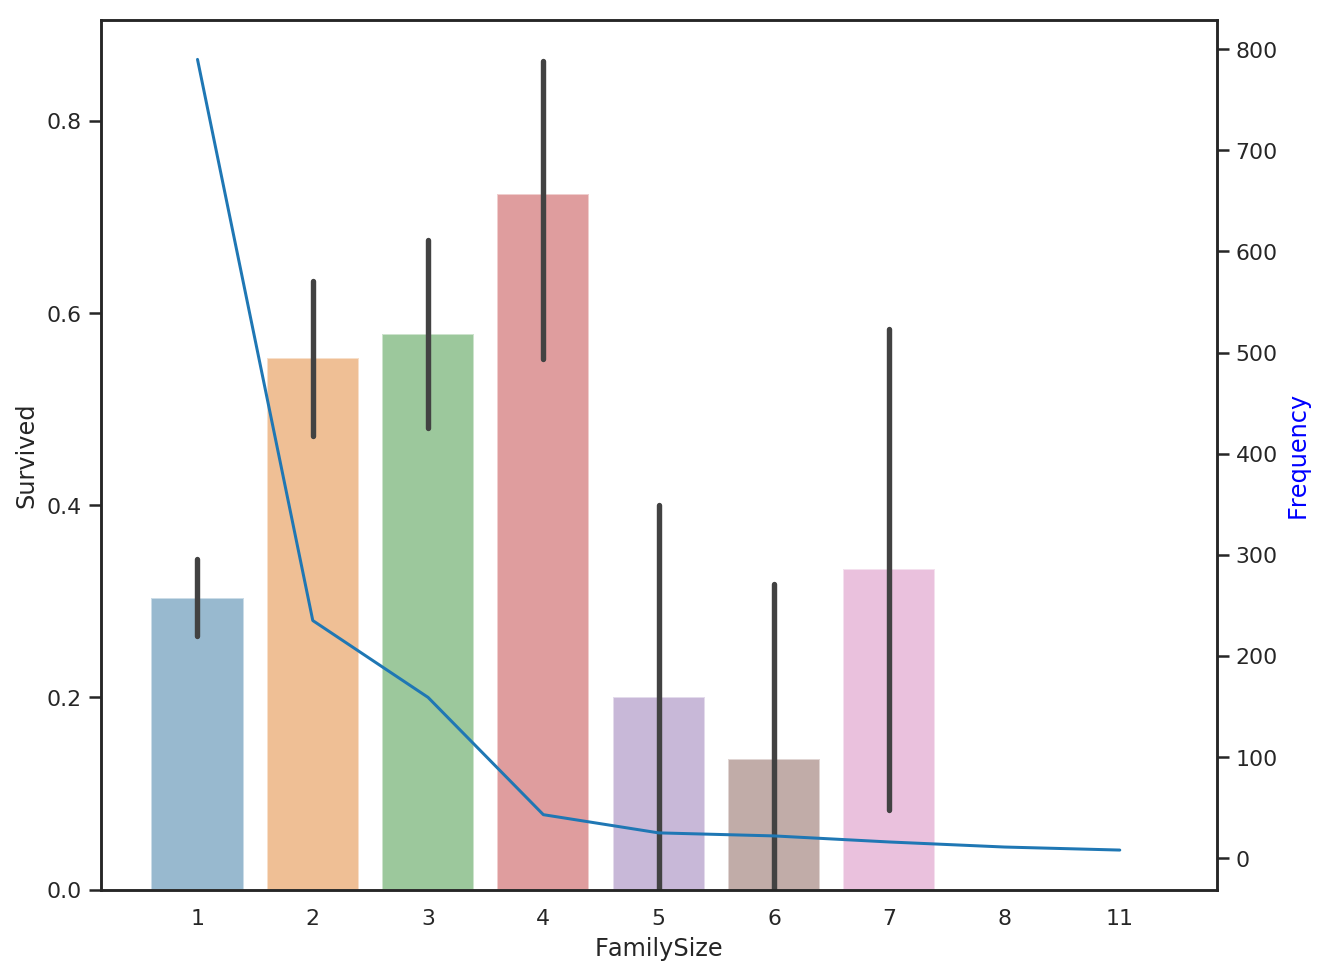

In [37]:
# SibSp and Parch -> Family Size

# switch of scipy.stats warning for enforced use of arr[np.array(seq)]
np.warnings.filterwarnings('ignore')

alldata[('FamilySize')] = alldata[('SibSp')] + alldata[('Parch')] + 1

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax = sns.barplot(x='FamilySize',y='Survived',data=alldata,alpha=0.5)
for c in ax.patches:
    c.set_zorder(0)

ax2 = ax.twinx()
_ = sns.lineplot(x=np.arange(0, len(alldata.FamilySize.unique())),
                        y=alldata.FamilySize.value_counts(),ax=ax2)

_ = ax2.set_ylabel('Frequency', color='b')

In [38]:
# Cat Codes for SibSp and Parch

alldata['FamilySize'] = alldata.FamilySize.astype('category').cat.codes + 1
print(alldata.FamilySize.value_counts())

alldata['SibSp'] = alldata.SibSp.astype('category').cat.codes + 1
alldata['Parch'] = alldata.Parch.astype('category').cat.codes + 1
print(alldata.SibSp.value_counts())
print(alldata.Parch.value_counts())

1    790
2    235
3    159
4     43
6     25
5     22
7     16
9     11
8      8
Name: FamilySize, dtype: int64
1    891
2    319
3     42
5     22
4     20
7      9
6      6
Name: SibSp, dtype: int64
1    1002
2     170
3     113
4       8
6       6
5       6
8       2
7       2
Name: Parch, dtype: int64


In [39]:
def parse_ticket(s:str)->(str, int):
    if s.strip(" ").isnumeric():
        return float('NaN'), int(s)
    elif s.strip(" ").isalpha():
        return s.strip(" "), int(0)
    else:
        try:
            xstr = s.replace('.','').replace('/','').strip(' ').split(' ')
            s,i = ''.join(xstr[0:-1]),xstr[-1]
            return s, int(i)
        except:
            xstr = s.replace('.','').replace('/','').strip(' ').split(' ')
            ss,i = ''.join(xstr[0:-1]),xstr[-1]
            print(s,ss, i)
    
alldata[["TKTHEADER","TKTNUM"]] = alldata.apply(lambda s: pd.Series(parse_ticket(s["Ticket"])),
                                                               axis=1)
alldata[['TKTHEADER','TKTNUM']].head()

,TKTHEADER,TKTNUM
0,A5,21171.0
1,PC,17599.0
2,STONO2,3101282.0
3,NaN,113803.0
4,NaN,373450.0


In [40]:
# cleaning up ticket data

alldata.drop(labels=['Ticket'], axis=1, inplace=True)

alldata['TKTHEADER'] = alldata.TKTHEADER.astype(str)
alldata['TKTNUM'] = alldata.TKTNUM.astype(np.int32)
alldata['TKTHEADER'] = alldata.TKTHEADER.astype('category').cat.codes + 1
alldata['TKTNUM'] = alldata.TKTNUM.astype('category').cat.codes + 1

print(list(alldata.columns))

print(alldata.TKTNUM.nunique())
print(alldata.TKTHEADER.nunique())

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'origin', 'Prefix', 'FamilySize', 'TKTHEADER', 'TKTNUM']
924
37


In [41]:
# Fares
print(alldata['Fare'].isnull().sum())

usecols = set(alldata.columns) - set(['Survived','Cabin',
                                      'origin','Embarked'])
predcol = 'Fare'

imputed_df = KNNfill(alldata,usecols,predcol,100)


1
Starting Imputation, Printing NaNs for Passed DataFrame::
TKTNUM        0
Parch         0
FamilySize    0
TKTHEADER     0
Fare          1
SibSp         0
Pclass        0
Sex           0
Prefix        0
Age           0
dtype: int64

1 values missing for Fare
Imputing row 1/1309 with 0 missing, elapsed time: 0.174
Imputing row 101/1309 with 0 missing, elapsed time: 0.174
Imputing row 201/1309 with 0 missing, elapsed time: 0.175
Imputing row 301/1309 with 0 missing, elapsed time: 0.175
Imputing row 401/1309 with 0 missing, elapsed time: 0.175
Imputing row 501/1309 with 0 missing, elapsed time: 0.175
Imputing row 601/1309 with 0 missing, elapsed time: 0.175
Imputing row 701/1309 with 0 missing, elapsed time: 0.175
Imputing row 801/1309 with 0 missing, elapsed time: 0.176
Imputing row 901/1309 with 0 missing, elapsed time: 0.176
Imputing row 1001/1309 with 0 missing, elapsed time: 0.176
Imputing row 1101/1309 with 0 missing, elapsed time: 0.176
Imputing row 1201/1309 with 0 missing, elaps

Median:16.751031675958156, Predicted:33.2954792813456


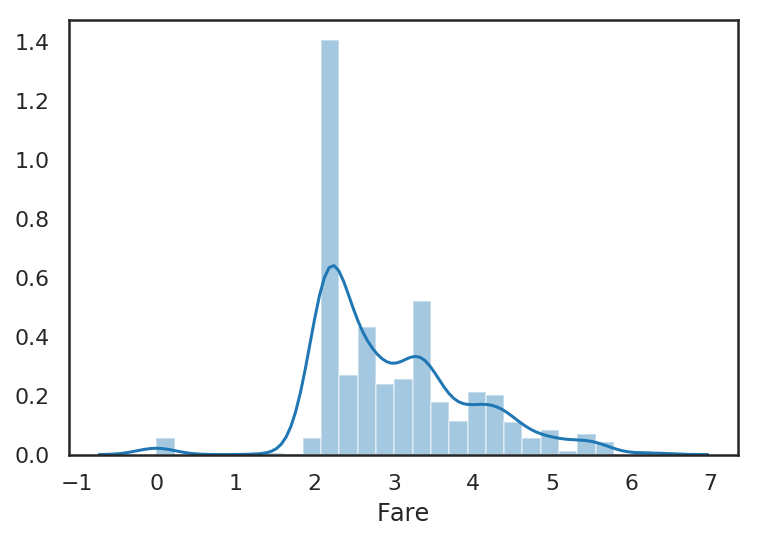

In [42]:
comp_fares = (float(imputed_df.loc[imputed_df['orig_Fare'].isnull(),('Fare')]),
              imputed_df.orig_Fare.mean())

print('Median:{}, Predicted:{}'.format(*comp_fares))

# logshift fares value 
alldata['Fare'] = np.log1p(imputed_df['Fare'])

sns.distplot(alldata['Fare'])

In [43]:
# discretizing fares

alldata['Fare'] = alldata['Fare'].map(lambda s: int(s/0.25))
alldata['Fare'] = alldata.Fare.astype('category').cat.codes + 1
print(alldata.Fare.value_counts())

5     409
10    176
7     138
6     104
9      77
8      73
14     72
12     49
11     48
13     45
15     26
16     20
18     18
1      17
19     16
17     13
20      4
4       2
3       1
2       1
Name: Fare, dtype: int64


In [44]:
# check progress
print(list(alldata.columns))

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'origin', 'Prefix', 'FamilySize', 'TKTHEADER', 'TKTNUM']


In [45]:
# Cabins

def parse_cabin(s):
    
    Decks = ['A','B','C','D','E','F','G','T']
    DeckSet = set()
    sc = s
    
    if type(s)==float:
        return float('NaN'), float('NaN')
    else:
        for deck_ in Decks:
            if deck_ in s:
                DeckSet.add(deck_)
                s = s.replace(deck_,"")
        if s == "":
            return tuple(DeckSet), float('NaN')
        else:
            Rooms = tuple(int(_s) for _s in s.strip(' ').split(' '))
            return tuple(DeckSet), tuple(Rooms)
        
alldata[['Deck','Cabin']] = alldata.apply(lambda s: pd.Series(parse_cabin(s["Cabin"])),axis=1)
alldata.loc[alldata['Deck'].notnull(), ('Deck','Cabin')].head()

,Deck,Cabin
1,"(C,)","(85,)"
3,"(C,)","(123,)"
6,"(E,)","(46,)"
10,"(G,)","(6,)"
11,"(C,)","(103,)"


In [46]:
alldata['Deck'] = alldata['Deck'].map(lambda s: 'N/A' if type(s)!=tuple else ''.join(s))
alldata['Cabin'] = alldata['Cabin'].map(lambda s: 'N/A' if type(s)!=tuple else len(s))
alldata.Deck.unique(), alldata.Cabin.unique()

(array(['N/A', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'GF', 'EF', 'T'],
       dtype=object), array(['N/A', 1, 3, 2, 4], dtype=object))

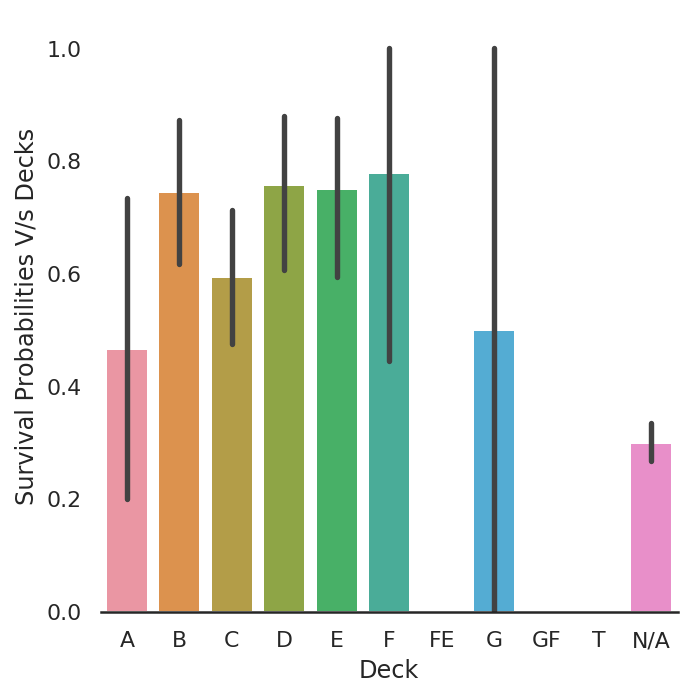

In [47]:
ax_dk  = sns.factorplot(x="Deck",y="Survived",data=alldata,kind="bar"
                        ,order=['A','B','C','D','E','F','FE','G','GF','T','N/A'])
ax_dk.despine(left=True)
ax_dk = ax_dk.set_ylabels("Survival Probabilities V/s Decks")

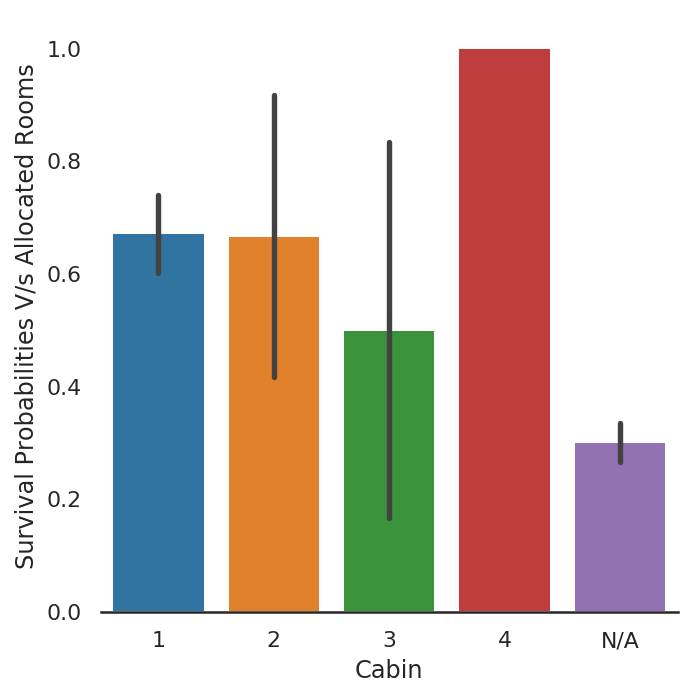

In [48]:
ax_cb  = sns.factorplot(x="Cabin",y="Survived",data=alldata,kind="bar"
                        ,order=[1,2,3,4,'N/A'])
ax_cb.despine(left=True)
ax_cb = ax_cb.set_ylabels("Survival Probabilities V/s Allocated Rooms")

In [49]:
alldata['Deck'] = alldata.Deck.astype('category').cat.codes + 1
alldata['Cabin'] = alldata.Cabin.astype('category').cat.codes + 1
print(alldata.Deck.value_counts())
print(alldata.Cabin.value_counts())

10    1014
3       94
2       65
4       46
5       41
1       22
7       14
8        5
9        4
6        3
11       1
Name: Deck, dtype: int64
5    1020
1     255
2      19
3      10
4       5
Name: Cabin, dtype: int64


In [50]:
# Embarked
alldata['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [51]:
EmbMap = {'C':0, 'Q':1, 'S':2}

alldata['Embarked'] = alldata['Embarked'].map(lambda s: np.nan if type(s)==float else EmbMap[str(s)])

alldata['Embarked'].isnull().sum()

2

In [52]:
usecols = set(alldata.columns) - set(['Survived','origin'])

predcol = 'Embarked'

imputed_df = KNNfill(alldata,usecols,predcol,100)

Starting Imputation, Printing NaNs for Passed DataFrame::
TKTNUM        0
Parch         0
FamilySize    0
TKTHEADER     0
Embarked      2
Fare          0
Cabin         0
Deck          0
SibSp         0
Pclass        0
Sex           0
Prefix        0
Age           0
dtype: int64

2 values missing for Embarked
Imputing row 1/1309 with 0 missing, elapsed time: 0.188
Imputing row 101/1309 with 0 missing, elapsed time: 0.189
Imputing row 201/1309 with 0 missing, elapsed time: 0.189
Imputing row 301/1309 with 0 missing, elapsed time: 0.189
Imputing row 401/1309 with 0 missing, elapsed time: 0.189
Imputing row 501/1309 with 0 missing, elapsed time: 0.189
Imputing row 601/1309 with 0 missing, elapsed time: 0.190
Imputing row 701/1309 with 0 missing, elapsed time: 0.190
Imputing row 801/1309 with 0 missing, elapsed time: 0.190
Imputing row 901/1309 with 0 missing, elapsed time: 0.190
Imputing row 1001/1309 with 0 missing, elapsed time: 0.190
Imputing row 1101/1309 with 0 missing, elapsed time: 

In [53]:
alldata['Embarked'] = imputed_df['Embarked']
alldata['Embarked'] = alldata.Embarked.map(lambda s: int(s))

alldata.Embarked.unique()

array([2, 0, 1])

In [54]:
# cat codes, meow!
alldata['Embarked'] = alldata.Embarked.astype('category').cat.codes + 1
print(alldata.Embarked.value_counts())
print('\n',list(alldata.columns))

3    914
1    270
2    125
Name: Embarked, dtype: int64

 ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'origin', 'Prefix', 'FamilySize', 'TKTHEADER', 'TKTNUM', 'Deck']


In [55]:
# droppping ticket numbers
tktnumbers = alldata.TKTNUM
alldata.drop(labels=['TKTNUM'], axis=1, inplace=True)

# cast Pclass
alldata['Pclass'] = alldata.Pclass.astype(np.uint8)

In [56]:
# forced typecasting

uint8check = lambda x: True if x.max() <= 255 else False

for col in alldata.columns:
    safestr = ''
    try:
        safestr = 'YES' if uint8check(alldata[col]) else '(!) NO'
        if uint8check(alldata[col]):
            alldata[col] = alldata[col].astype(np.uint8)
    except:
        print('(!) Exception at: ',col)
        safestr = '(!) NO'
    print("{}: UINT8 Safe:\033[1m{}\033[0m, Type:{}".format(col,
                                            safestr,
                                            alldata[col].dtype))




(!) Exception at:  Survived
Survived: UINT8 Safe:(!) NO, Type:float64
Pclass: UINT8 Safe:YES, Type:uint8
Sex: UINT8 Safe:YES, Type:uint8
Age: UINT8 Safe:YES, Type:uint8
SibSp: UINT8 Safe:YES, Type:uint8
Parch: UINT8 Safe:YES, Type:uint8
Fare: UINT8 Safe:YES, Type:uint8
Cabin: UINT8 Safe:YES, Type:uint8
Embarked: UINT8 Safe:YES, Type:uint8
(!) Exception at:  origin
origin: UINT8 Safe:(!) NO, Type:object
Prefix: UINT8 Safe:YES, Type:uint8
FamilySize: UINT8 Safe:YES, Type:uint8
TKTHEADER: UINT8 Safe:YES, Type:uint8
Deck: UINT8 Safe:YES, Type:uint8


# Model Building

In [57]:
# prepare testing and training datasets

train = alldata.copy().loc[alldata['origin']=='train']
test = alldata.copy().loc[alldata['origin']=='test']


train.drop(labels=['origin'], axis=1, inplace=True)
train['Survived'] = train['Survived'].astype(np.uint8)
test.drop(labels=['Survived', 'origin'], axis = 1, inplace=True)

print(train.shape, test.shape)

X_train, Y_train = train.drop(labels=['Survived'], axis=1), train.Survived.astype(np.int8)

X_test = test.copy()

X_train.shape, Y_train.shape, X_test.shape

(891, 13) (418, 12)


((891, 12), (891,), (418, 12))

In [58]:
# split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X_sk_train, X_sk_test, Y_sk_train, Y_sk_test = train_test_split(X_train,
                                                                Y_train,
                                                                train_size = 0.8,
                                                                test_size = 0.2)

kfold = StratifiedKFold(9)

In [59]:
from dask.distributed import Client
client = Client(n_workers=8, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:40915 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 33.66 GB


In [60]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=1024,
                      population_size=128,
                      scoring='accuracy',
                      cv=kfold,
                      config_dict='TPOT light',
                      n_jobs=-1,
                      use_dask=True,
                      random_state=42,
                      memory='auto',
                      periodic_checkpoint_folder='../data',
                      early_stop=32,
                      warm_start=True,
                      verbosity=2)
tpot.fit(X_sk_train, Y_sk_train)
print(tpot.score(X_sk_test, Y_sk_test))
tpot.export('../data/tpot_titanic.py')

Generation 1 - Current best internal CV score: 0.8326278444949331
Generation 2 - Current best internal CV score: 0.8326278444949331
Generation 3 - Current best internal CV score: 0.8327869739262144
Generation 4 - Current best internal CV score: 0.8383957228893938
Generation 5 - Current best internal CV score: 0.8397683832810414
Generation 6 - Current best internal CV score: 0.8397683832810414
Generation 7 - Current best internal CV score: 0.8397683832810414
Generation 8 - Current best internal CV score: 0.8397683832810414
Generation 9 - Current best internal CV score: 0.8425980020916729
Generation 10 - Current best internal CV score: 0.8425980020916729
Generation 11 - Current best internal CV score: 0.8425980020916729
Generation 12 - Current best internal CV score: 0.8468178621659633
Generation 13 - Current best internal CV score: 0.8468178621659633
Generation 14 - Current best internal CV score: 0.8468178621659633
Generation 15 - Current best internal CV score: 0.8468178621659633
Gene

TPOTClassifier(config_dict='TPOT light', crossover_rate=0.1,
        cv=StratifiedKFold(n_splits=9, random_state=None, shuffle=False),
        disable_update_check=False, early_stop=32, generations=1024,
        max_eval_time_mins=5, max_time_mins=None, memory='auto',
        mutation_rate=0.9, n_jobs=-1, offspring_size=None,
        periodic_checkpoint_folder='../data', population_size=128,
        random_state=42, scoring='accuracy', subsample=1.0, use_dask=True,
        verbosity=2, warm_start=True)

0.8044692737430168


True